# Data Ingest

Access data stored on s3 and explore with Athena

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


[04/14/25 06:18:01] INFO     generated new fontManager                                         ]8;id=227637;file:///opt/conda/lib/python3.11/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=975590;file:///opt/conda/lib/python3.11/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

Set up sagemaker instance

In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

Verify objects in public bucket

In [3]:
!aws s3 ls s3://ads-508-final/playstation/

                           PRE achievements/
                           PRE games/
                           PRE history/
                           PRE players/
                           PRE prices/
                           PRE purchased_games/


In [4]:
# set path for public bucket
s3_playstation_path_public = 's3://ads-508-final/playstation/'

In [5]:
# set staging directory in private bucket
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [6]:
# create connection with pyathena
# EXPLORE USING ENGINE
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)

In [7]:
# define database name
database_name = "playstationaws"

In [8]:
# create database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement) 

CREATE DATABASE IF NOT EXISTS playstationaws


In [9]:
# execute query to create database
pd.read_sql(statement, conn)

""


In [10]:
# execute query to show database is present
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,default
1,playstationaws


## Fix the underlying data

The datafix notebook properly overwrites data to account for JSON arrays in the csv files

## Load data into Athena tables for analysis

Confirm process and load with `games` data, then iterate through and create remaining tables

In [11]:
# define table names based on datasets
table_names = ['achievements', 'games', 'history', 'players', 'prices', 'purchased_games']

In [12]:
# drop tables if needed
for name in table_names:
    pd.read_sql("""DROP TABLE IF EXISTS {}.{};""".format(database_name, name), conn)

In [13]:
# create table for games data
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS playstationaws.games (
                    game_id STRING,
                    title STRING,
                    platform STRING,
                    developers STRING,
                    publishers STRING,
                    genres STRING,
                    supported_languages STRING,
                    release_date STRING
                )
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
                WITH SERDEPROPERTIES (
                    "separatorChar" = ",",
                    "quoteChar" = "\\""
                )
                LOCATION 's3://ads-508-final/playstation/games/'
                TBLPROPERTIES ('skip.header.line.count'='1', 'compressionType'='gzip');"""

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS playstationaws.games (
                    game_id STRING,
                    title STRING,
                    platform STRING,
                    developers STRING,
                    publishers STRING,
                    genres STRING,
                    supported_languages STRING,
                    release_date STRING
                )
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
                WITH SERDEPROPERTIES (
                    "separatorChar" = ",",
                    "quoteChar" = "\""
                )
                LOCATION 's3://ads-508-final/playstation/games/'
                TBLPROPERTIES ('skip.header.line.count'='1', 'compressionType'='gzip');


In [14]:
# execute query to create table and load data
pd.read_sql(statement, conn)

""


In [15]:
# define query and check load
statement = """select * from {}.games limit 50""".format(database_name)

In [16]:
df = pd.read_sql(statement, conn)

In [19]:
tables = []

In [20]:
# create table for achievements data
statement_ach = """create external table if not exists {}.{} (
            achievementid string,
            gameid string,
            title string,
            description string,
            rarity string
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}achievements/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[0], s3_playstation_path_public
        )

tables.append(statement_ach)

In [21]:
# create table for history data
statement_hist = """create external table if not exists {}.{} (
            playerid string,
            achievementid string,
            date_acquired date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}history/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[2], s3_playstation_path_public
        )

tables.append(statement_hist)

In [22]:
# create table for players data
statement_pla = """create external table if not exists {}.{} (
            playerid string,
            nickname string,
            country string
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}players/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[3], s3_playstation_path_public
        )

tables.append(statement_pla)

In [23]:
# create table for prices data
statement_pri = """create external table if not exists {}.{} (
            gameid string,
            usd int,
            eur int,
            gbp int,
            jpy int,
            rub int,
            date_acquired date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}prices/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[4], s3_playstation_path_public
        )

tables.append(statement_pri)

In [24]:
# create table for purchased_games data
statement_pur = """create external table if not exists playstationaws.purchased_games (
            playerid string,
            library string
            )
            ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
                    WITH SERDEPROPERTIES (
                        "separatorChar" = ",",
                        "quoteChar" = "\\""
            )
            LOCATION 's3://ads-508-final/playstation/purchased_games/'
            TBLPROPERTIES ('skip.header.line.count'='1', 'compressionType'='gzip');"""

tables.append(statement_pur)

In [25]:
for statement in tables:
    pd.read_sql(statement, conn)
    print(f"creating table {statement}...")

creating table create external table if not exists playstationaws.achievements (
            achievementid string,
            gameid string,
            title string,
            description string,
            rarity string
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\n'
        location 's3://ads-508-final/playstation/achievements/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');...
creating table create external table if not exists playstationaws.history (
            playerid string,
            achievementid string,
            date_acquired date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\n'
        location 's3://ads-508-final/playstation/history/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');...
creating table create external table if not exists playstationaws.players (
            playerid string,


## Creating dataframes for EDA

In [29]:
#Create DF for Purchased games
statement = """select * from {}.purchased_games""".format(database_name)
df_purchased_games = pd.read_sql(statement, conn)
df_purchased_games.head(10)

,playerid,library
0,268071,"[14972, 417905, 14693, 7742, 20162, 461983, 12..."
1,2218485,"[410618, 17456, 16034, 138931, 175202, 331007,..."
2,253885,"[417808, 706747, 619583, 492711, 555631, 18167..."
3,1911732,"[670209, 694794, 658551, 582894, 602666, 65531..."
4,3098524,"[19362, 170350, 12653, 20230, 12750, 18141, 41..."
5,4142496,"[726853, 453158, 514019, 555866, 553336, 683, ..."
6,411404,"[9459, 333860, 11989, 420057, 404720, 8336, 13..."
7,36315,"[1021, 811, 3593, 666, 253, 147, 169, 446, 15,..."
8,4605390,"[12653, 9459, 334328, 643858, 176538, 494230, ..."
9,301459,"[408903, 418331, 333860, 20006, 415595, 168465..."


In [30]:
#Create DF for Achivements
statement = """select * from {}.achievements""".format(database_name)
df_achievements = pd.read_sql(statement, conn)
df_achievements.head(10)

,achievementid,gameid,title,description,rarity
0,17200_169729,17200,A New Birth?,Survived the Lifecut case.,Gold
1,17200_169730,17200,Resolution?,Survived the Danwa case.,Gold
2,17200_169731,17200,White Out prologue,Survived the White Out prologue case.,Gold
3,17200_169732,17200,Dream,Completed the YUME investigation.,Bronze
4,17200_169733,17200,Flower,Completed the HANA investigation.,Silver
5,17200_169734,17200,Moon,Completed the TSUKI investigation.,Silver
6,17200_169735,17200,Love,Completed the AI investigation.,Silver
7,17200_169736,17200,Light,Completed the HIKARI investigation.,Gold
8,17200_169737,17200,Darkness,Completed the YAMI investigation.,Gold
9,17200_169738,17200,Avid Reader,Collected the 2nd Comic Beam.,Bronze


In [33]:
#Create DF for History
statement = """select * from {}.history limit 5000""".format(database_name)
df_history = pd.read_sql(statement, conn)
df_history.head(10)

,playerid,achievementid,date_acquired
0,1911732,670209_5436079,2024-11-28
1,1911732,670209_5436078,2024-11-28
2,1911732,670209_5436077,2024-11-28
3,1911732,670209_5436076,2024-11-28
4,1911732,658551_5368954,2024-10-05
5,1911732,658551_5368961,2024-10-05
6,1911732,658551_5368958,2024-10-05
7,1911732,658551_5368969,2024-10-05
8,1911732,658551_5368967,2024-10-05
9,1911732,658551_5368955,2024-10-05


In [34]:
#Create DF for Games
statement = """select * from {}.games""".format(database_name)
df_games = pd.read_sql(statement, conn)
df_games.head(10)

,game_id,title,platform,developers,publishers,genres,supported_languages,release_date
0,749375,Medieval Match Master,PS4,['Erik Games'],['Erik Games'],['Puzzle'],,2024-11-22
1,749839,Sunforge Solar Survival,PS4,['GrizzlyGames'],['GrizzlyGames'],,,2024-11-21
2,749347,Find Love Or Die Trying,PS5,['Sunseeker Games'],['Ratalaika Games'],['Visual Novel'],,2024-11-22
3,749341,Medieval Match Master,PS4,['Erik Games'],['Erik Games'],['Puzzle'],,2024-11-22
4,749097,Bust A Block 2,PS5,['ThiGames'],['ThiGames'],['Puzzle'],,2024-11-21
5,749095,Bust A Block 2,PS4,['ThiGames'],['ThiGames'],['Puzzle'],,2024-11-21
6,746306,Trading Card Shop Simulator,PS5,['NOSTRA GAMES'],['NOSTRA GAMES'],['Simulation'],,2024-11-14
7,746215,Trading Card Shop Simulator,PS5,['NOSTRA GAMES'],['NOSTRA GAMES'],['Simulation'],,2024-11-14
8,745840,Sprawl,PS5,['MAETH'],['Rogue Games'],['First Person Shooter'],,2024-11-21
9,746216,Trading Card Shop Simulator,PS4,['NOSTRA GAMES'],['NOSTRA GAMES'],['Simulation'],,2024-11-14


In [35]:
#Create DF for Players
statement = """select * from {}.players""".format(database_name)
df_players = pd.read_sql(statement, conn)
df_players.head(10)

,playerid,nickname,country
0,2744567,ieizazuBisnorog,Croatia
1,328452,DiscoGitaroo,United States
2,2521482,Ectivey,United Kingdom
3,390175,Tomie_Again,"""Korea"
4,4348945,Lordhell1986,Russian Federation
5,1881650,Syruth,Chile
6,379001,milanbarca82,Saudi Arabia
7,3877529,LMZ-W,United States
8,2552501,Michael-_-Vork82,Denmark
9,1775323,WesSiebra,Brazil


In [36]:
#Create DF for Prices
statement = """select * from {}.prices""".format(database_name)
df_prices = pd.read_sql(statement, conn)
df_prices.head(10)

,gameid,usd,eur,gbp,jpy,rub,date_acquired
0,749347,10.0,10.0,7.0,1408.0,929.0,2025-02-22
1,749281,1.0,1.0,1.0,220.0,NaN,2025-02-22
2,749839,14.0,14.0,11.0,2310.0,1069.0,2025-02-22
3,749280,1.0,1.0,1.0,220.0,NaN,2025-02-22
4,749375,0.0,0.0,0.0,165.0,71.0,2025-02-22
5,749636,5.0,5.0,4.0,700.0,429.0,2025-02-22
6,749282,1.0,1.0,1.0,220.0,NaN,2025-02-22
7,749341,0.0,0.0,0.0,165.0,71.0,2025-02-22
8,749865,5.0,5.0,4.0,700.0,429.0,2025-02-22
9,749097,1.0,1.0,1.0,220.0,NaN,2025-02-22


In [44]:
# 1. Check for missing values
missing_values_players = df_players.isnull().sum()
missing_values_prices = df_prices.isnull().sum()
missing_values_history = df_history.isnull().sum()
missing_values_games = df_games.isnull().sum()
missing_values_purchased_games = df_purchased_games.isnull().sum()
missing_values_achievements = df_achievements.isnull().sum()

# 2. Check for duplicates
duplicates_players = df_players.duplicated().sum()
duplicates_prices = df_prices.duplicated().sum()
duplicates_history = df_history.duplicated().sum()
duplicates_games = df_games.duplicated().sum()
duplicates_purchased_games = df_purchased_games.duplicated().sum()
duplicates_achievements = df_achievements.duplicated().sum()

# 3. Summary statistics for numerical columns
summary_players = df_players.describe()
summary_prices = df_prices.describe()
summary_history = df_history.describe()
summary_games = df_games.describe()
summary_purchased_games = df_purchased_games.describe()
summary_achievements = df_achievements.describe()

# 4. Column data types
data_types_players = df_players.dtypes
data_types_prices = df_prices.dtypes
data_types_history = df_history.dtypes
data_types_games = df_games.dtypes
data_types_purchased_games = df_purchased_games.dtypes
data_types_achievements = df_achievements.dtypes

In [45]:
# Format Missing Values in df_players and df_prices
missing_values_players = df_players.isnull().sum().reset_index()
missing_values_players.columns = ['Column', 'Missing Values']
missing_values_players = missing_values_players[missing_values_players['Missing Values'] > 0]

missing_values_prices = df_prices.isnull().sum().reset_index()
missing_values_prices.columns = ['Column', 'Missing Values']
missing_values_prices = missing_values_prices[missing_values_prices['Missing Values'] > 0]

missing_values_history = df_history.isnull().sum().reset_index()
missing_values_history.columns = ['Column', 'Missing Values']
missing_values_history = missing_values_history[missing_values_history['Missing Values'] > 0]

missing_values_games = df_games.isnull().sum().reset_index()
missing_values_games.columns = ['Column', 'Missing Values']
missing_values_games = missing_values_games[missing_values_games['Missing Values'] > 0]

missing_values_purchased_games = df_purchased_games.isnull().sum().reset_index()
missing_values_purchased_games.columns = ['Column', 'Missing Values']
missing_values_purchased_games = missing_values_purchased_games[missing_values_purchased_games['Missing Values'] > 0]

missing_values_achievements = df_achievements.isnull().sum().reset_index()
missing_values_achievements.columns = ['Column', 'Missing Values']
missing_values_achievements = missing_values_achievements[missing_values_achievements['Missing Values'] > 0]


# Get summary statistics for df_players and df_prices
summary_players = df_players.describe().transpose()
summary_prices = df_prices.describe().transpose()
summary_history = df_history.describe().transpose()
summary_games = df_games.describe().transpose()
summary_purchased_games = df_purchased_games.describe().transpose()
summary_achievements = df_achievements.describe().transpose()

# Data Type Information
data_types_players = pd.DataFrame(df_players.dtypes, columns=['Data Type'])
data_types_prices = pd.DataFrame(df_prices.dtypes, columns=['Data Type'])
data_types_history = pd.DataFrame(df_history.dtypes, columns=['Data Type'])
data_types_games = pd.DataFrame(df_games.dtypes, columns=['Data Type'])
data_types_purchased_games = pd.DataFrame(df_purchased_games.dtypes, columns=['Data Type'])
data_types_achievements = pd.DataFrame(df_achievements.dtypes, columns=['Data Type'])

# Display the formatted results
print("=== Missing Values in Players Dataset ===")
print(missing_values_players.to_string(index=False))

print("\n=== Missing Values in Prices Dataset ===")
print(missing_values_prices.to_string(index=False))

print("=== Missing Values in History Dataset ===")
print(missing_values_history.to_string(index=False))

print("\n=== Missing Values in Games Dataset ===")
print(missing_values_games.to_string(index=False))

print("=== Missing Values in Purchased Games Dataset ===")
print(missing_values_purchased_games.to_string(index=False))

print("\n=== Missing Values in Achievements Dataset ===")
print(missing_values_achievements.to_string(index=False))

print(f"\n=== Duplicates in Players Dataset: {duplicates_players} ===")
print(f"=== Duplicates in Prices Dataset: {duplicates_prices} ===")
print(f"\n=== Duplicates in History Dataset: {duplicates_history} ===")
print(f"=== Duplicates in Games Dataset: {duplicates_games} ===")
print(f"\n=== Duplicates in Purchased Games Dataset: {duplicates_purchased_games} ===")
print(f"=== Duplicates in Achievements Dataset: {duplicates_achievements} ===")

# Print Summary Statistics
print("\n=== Summary Statistics for Players Dataset ===")
print(summary_players)

print("\n=== Summary Statistics for Prices Dataset ===")
print(summary_prices)

print("\n=== Summary Statistics for History Dataset ===")
print(summary_history)

print("\n=== Summary Statistics for Games Dataset ===")
print(summary_games)

print("\n=== Summary Statistics for Purchased Games Dataset ===")
print(summary_purchased_games)

print("\n=== Summary Statistics for Achievements Dataset ===")
print(summary_achievements)




# Print Data Types
print("\n=== Data Types for Players Dataset ===")
print(data_types_players)

print("\n=== Data Types for Prices Dataset ===")
print(data_types_prices)

print("\n=== Data Types for History Dataset ===")
print(data_types_history)

print("\n=== Data Types for Games Dataset ===")
print(data_types_games)

print("\n=== Data Types for Purchased Games Dataset ===")
print(data_types_purchased_games)

print("\n=== Data Types for Achievements Dataset ===")
print(data_types_achievements)

=== Missing Values in Players Dataset ===
Empty DataFrame
Columns: [Column, Missing Values]
Index: []

=== Missing Values in Prices Dataset ===
Column  Missing Values
   usd           13565
   eur           15552
   gbp           14179
   jpy           35778
   rub           51905
=== Missing Values in History Dataset ===
Empty DataFrame
Columns: [Column, Missing Values]
Index: []

=== Missing Values in Games Dataset ===
             Column  Missing Values
              title               1
           platform               1
         developers               1
         publishers               2
             genres               2
supported_languages               2
       release_date               2
=== Missing Values in Purchased Games Dataset ===
Empty DataFrame
Columns: [Column, Missing Values]
Index: []

=== Missing Values in Achievements Dataset ===
     Column  Missing Values
     gameid            3489
      title           11229
description           12012
     rarity      

## Data exploration and visualization

Explore tables in our database

#### Apply initial formatting for visualizations

In [37]:
sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

In [38]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

### Games

#### What are the top 25 genres by volume in the game categlog on Playstation?

In [39]:
statement = """select genres, count(*) as total
    from {}.games
    group by genres
    order by total desc
    limit 25
""".format(database_name)

df_genre = pd.read_sql(statement, conn)
df_genre

,genres,total
0,['Action'],3031
1,['Platformer'],1858
2,['Puzzle'],1850
3,['Indie'],1389
4,['Adventure'],1320
5,"[""Shoot 'em up""]",1142
6,['Visual Novel'],703
7,['Simulation'],649
8,['Action-Adventure'],625
9,['strategy'],467


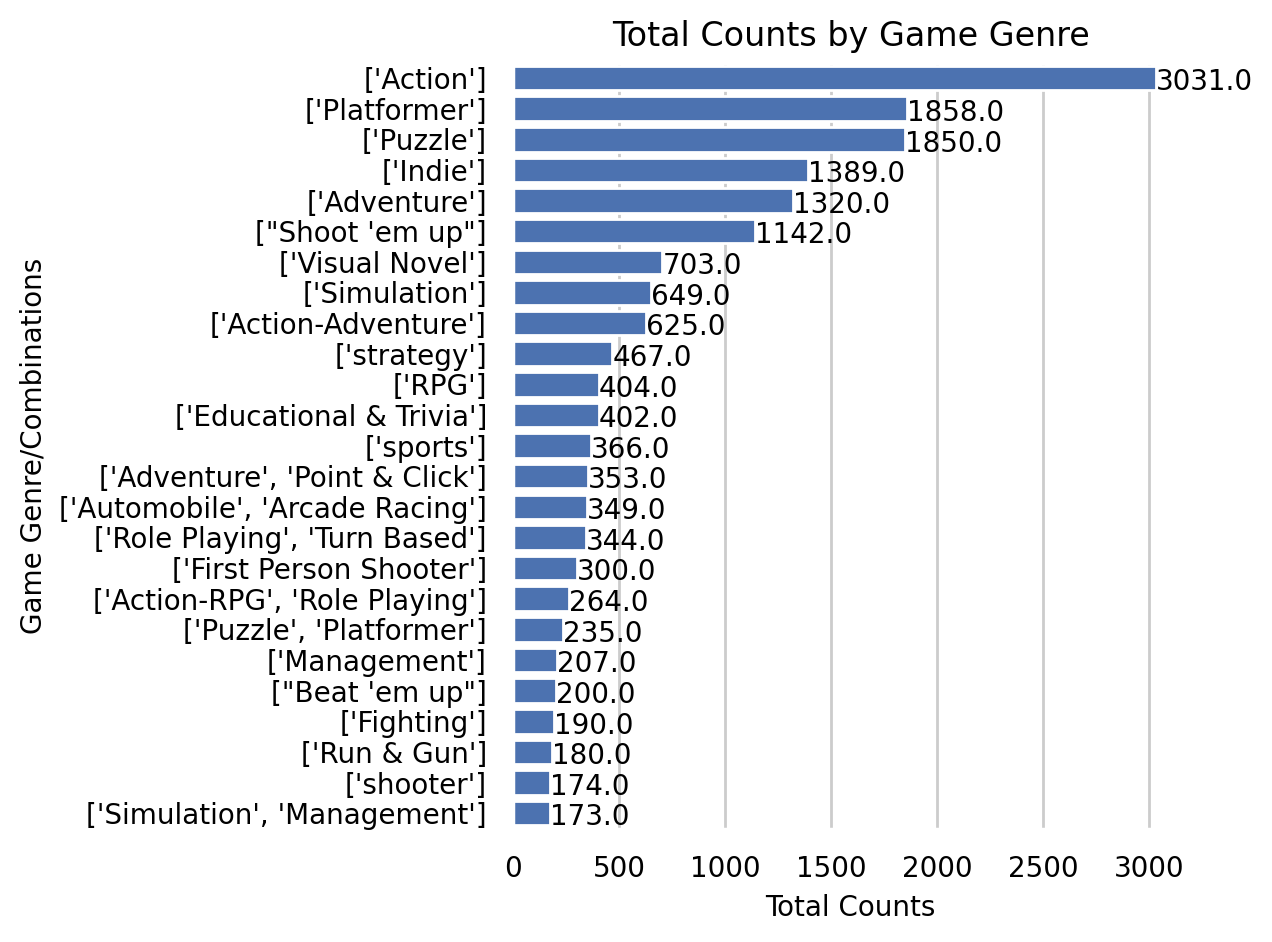

In [40]:
barplot = sns.barplot(y="genres", x="total", data=df_genre, saturation=1)

# Set title and x-axis ticks
plt.title("Total Counts by Game Genre")

# Helper code to show actual values afters bars
show_values_barplot(barplot, 0.1)

plt.xlabel("Total Counts")
plt.ylabel("Game Genre/Combinations")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

#### How many Indie games were made each year? 

### Purchased Games

In [41]:
statement = """select 
            EXTRACT(year FROM CAST(release_date AS date)) AS year,
            COUNT(*) AS total
            FROM {}.games
            WHERE genres like '%Indie%'
            GROUP BY EXTRACT(year FROM CAST(release_date AS date))
            ORDER BY year
""".format(database_name)

df_indie = pd.read_sql(statement, conn)
df_indie

,year,total
0,2009,4
1,2010,5
2,2011,9
3,2012,8
4,2013,26
5,2014,29
6,2015,35
7,2016,125
8,2017,202
9,2018,270


[04/14/25 16:04:10] INFO     Using categorical units to plot a list of strings that are all         ]8;id=138846;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=395913;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=632187;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=584990;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

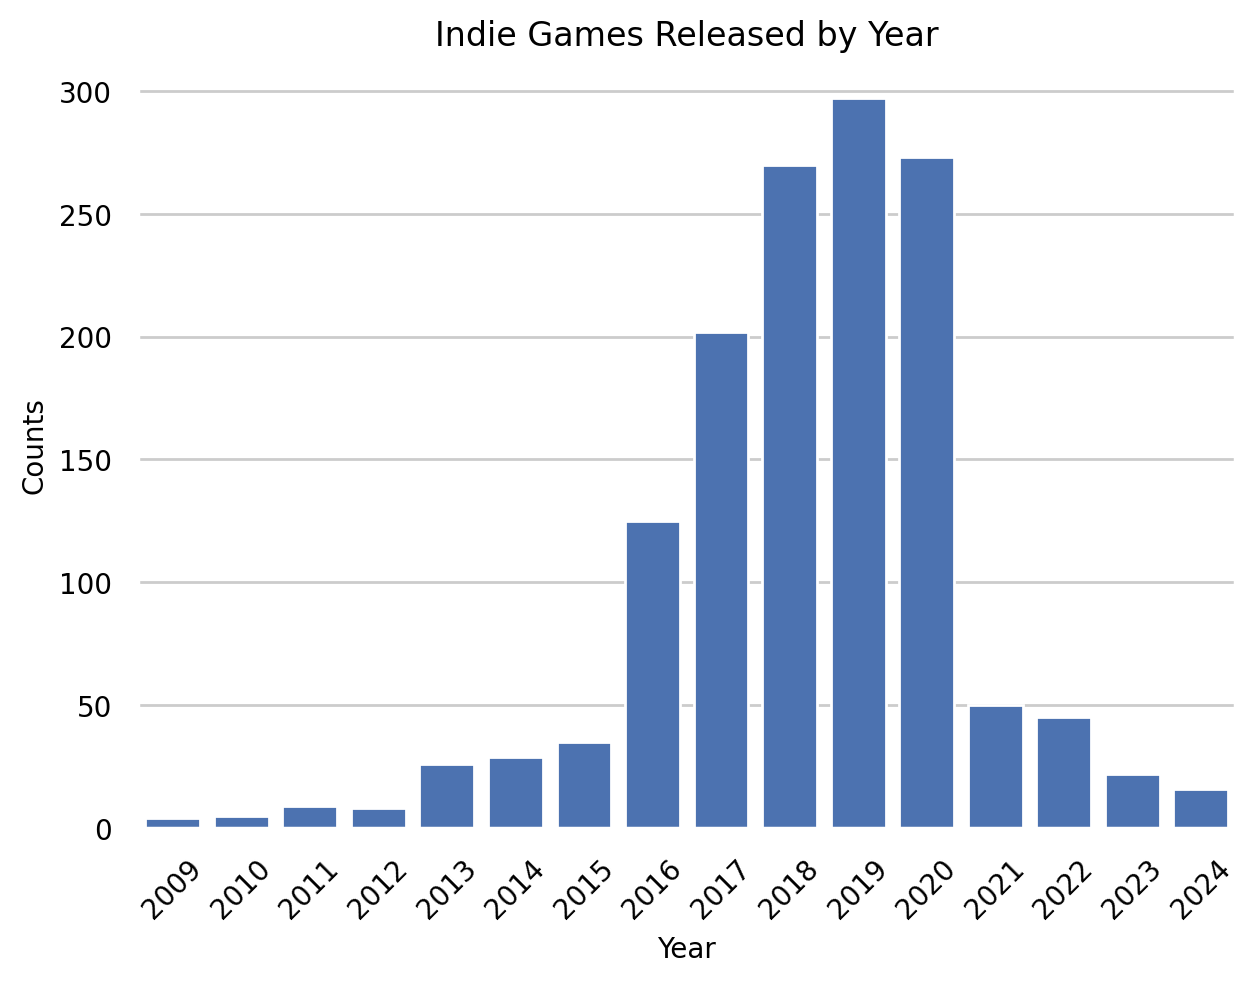

In [42]:
df_indie['year'] = pd.to_numeric(df_indie['year'], errors='coerce')
df_indie['total'] = pd.to_numeric(df_indie['total'], errors='coerce')


barplot = sns.barplot(x="year", y="total", data=df_indie, saturation=1)

# Set title and x-axis ticks
plt.title("Indie Games Released by Year")

plt.xlabel("Year")
plt.ylabel("Counts")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

plt.xticks(rotation=45)

# Show graphic
plt.show(barplot)

/tmp/ipykernel_335/3247474045.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='country', data=df_players[df_players['country'].isin(top_15_countries)],


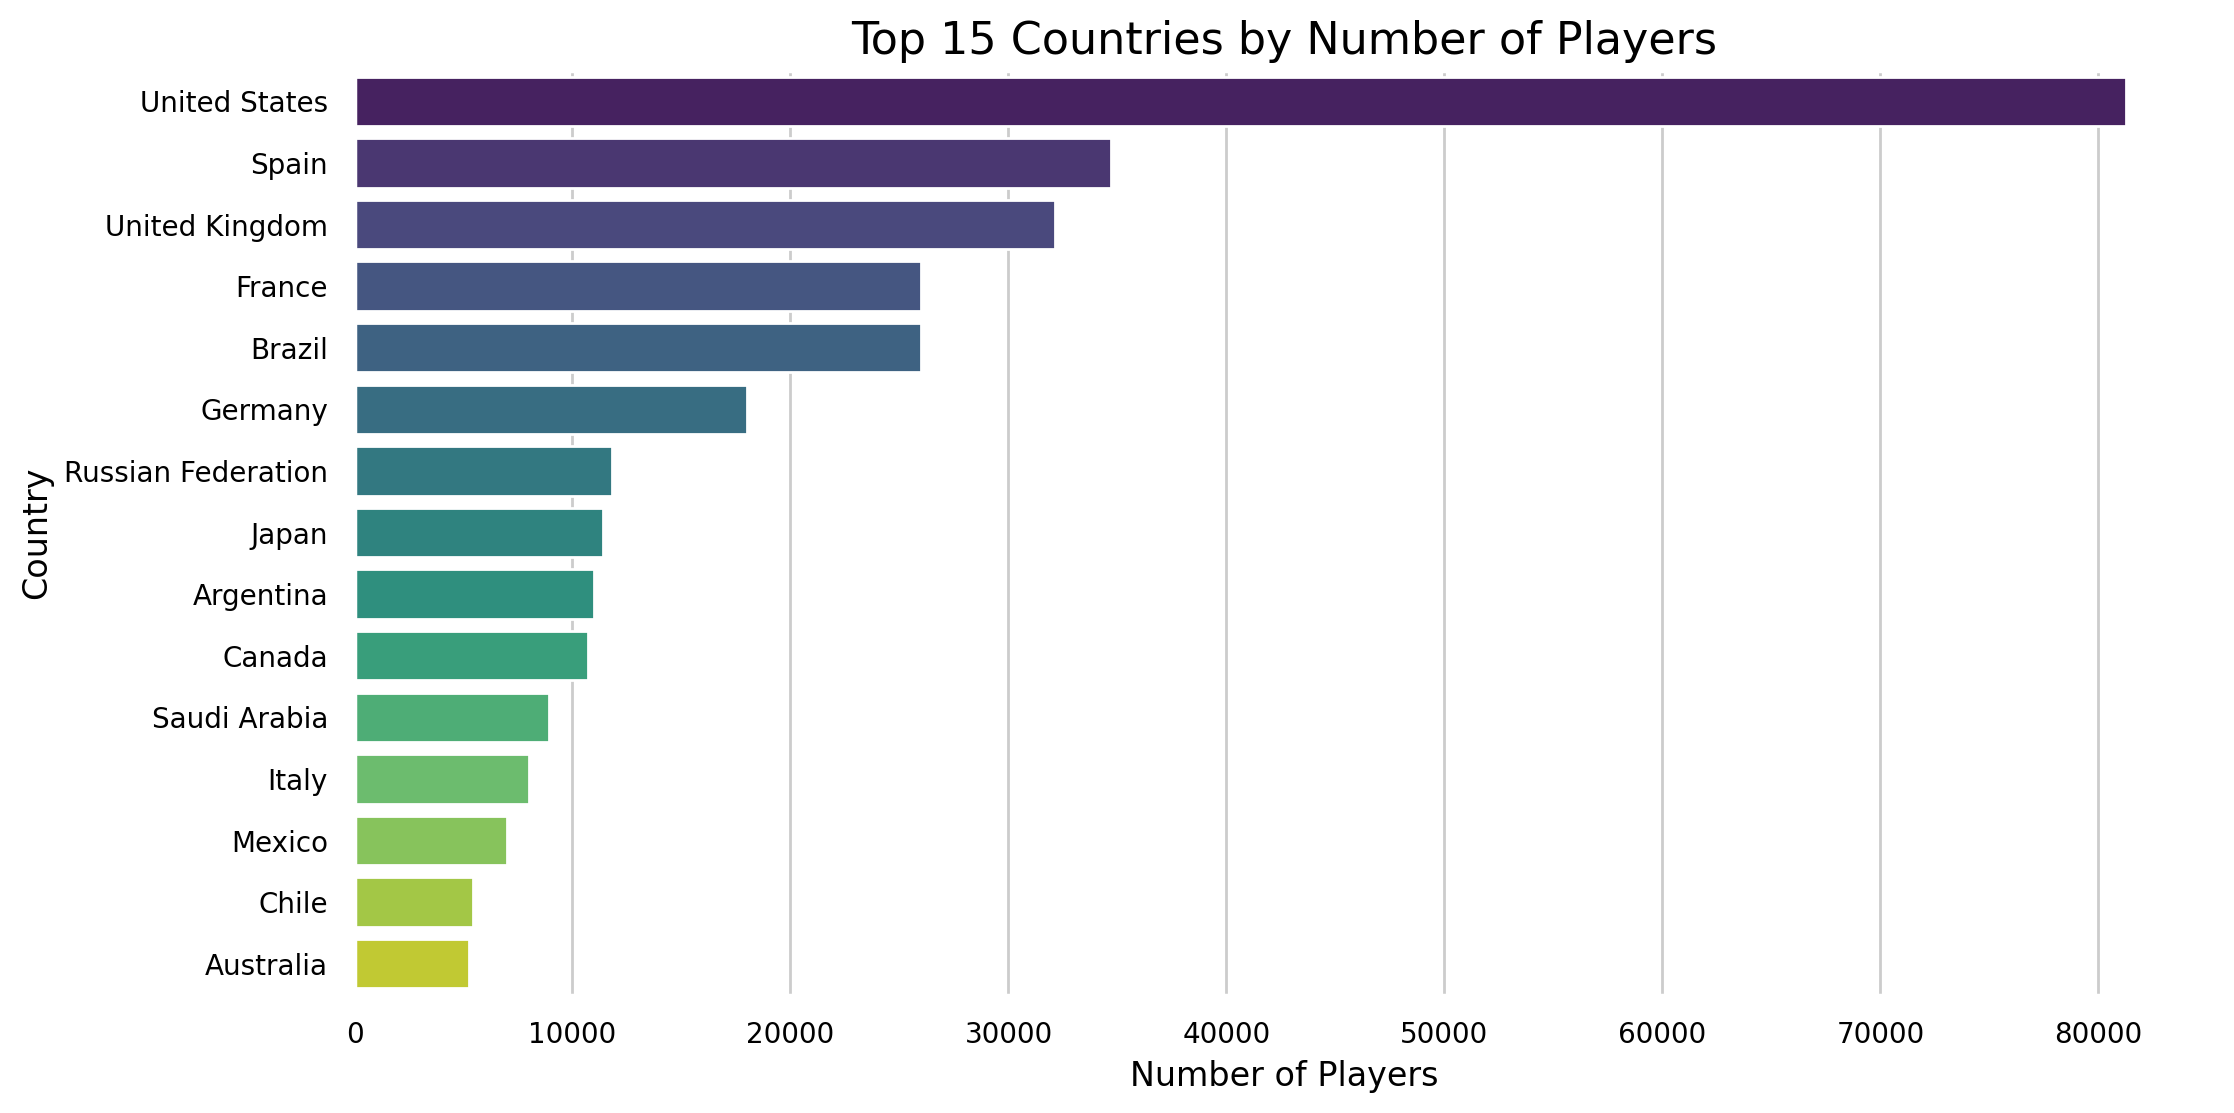

In [47]:
# Distribution of Top 15 Countries by Player Count
plt.figure(figsize=(12, 6))
top_15_countries = df_players['country'].value_counts().head(15).index
sns.countplot(y='country', data=df_players[df_players['country'].isin(top_15_countries)],
              order=top_15_countries, palette='viridis')
plt.title('Top 15 Countries by Number of Players', fontsize=16)
plt.xlabel('Number of Players', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

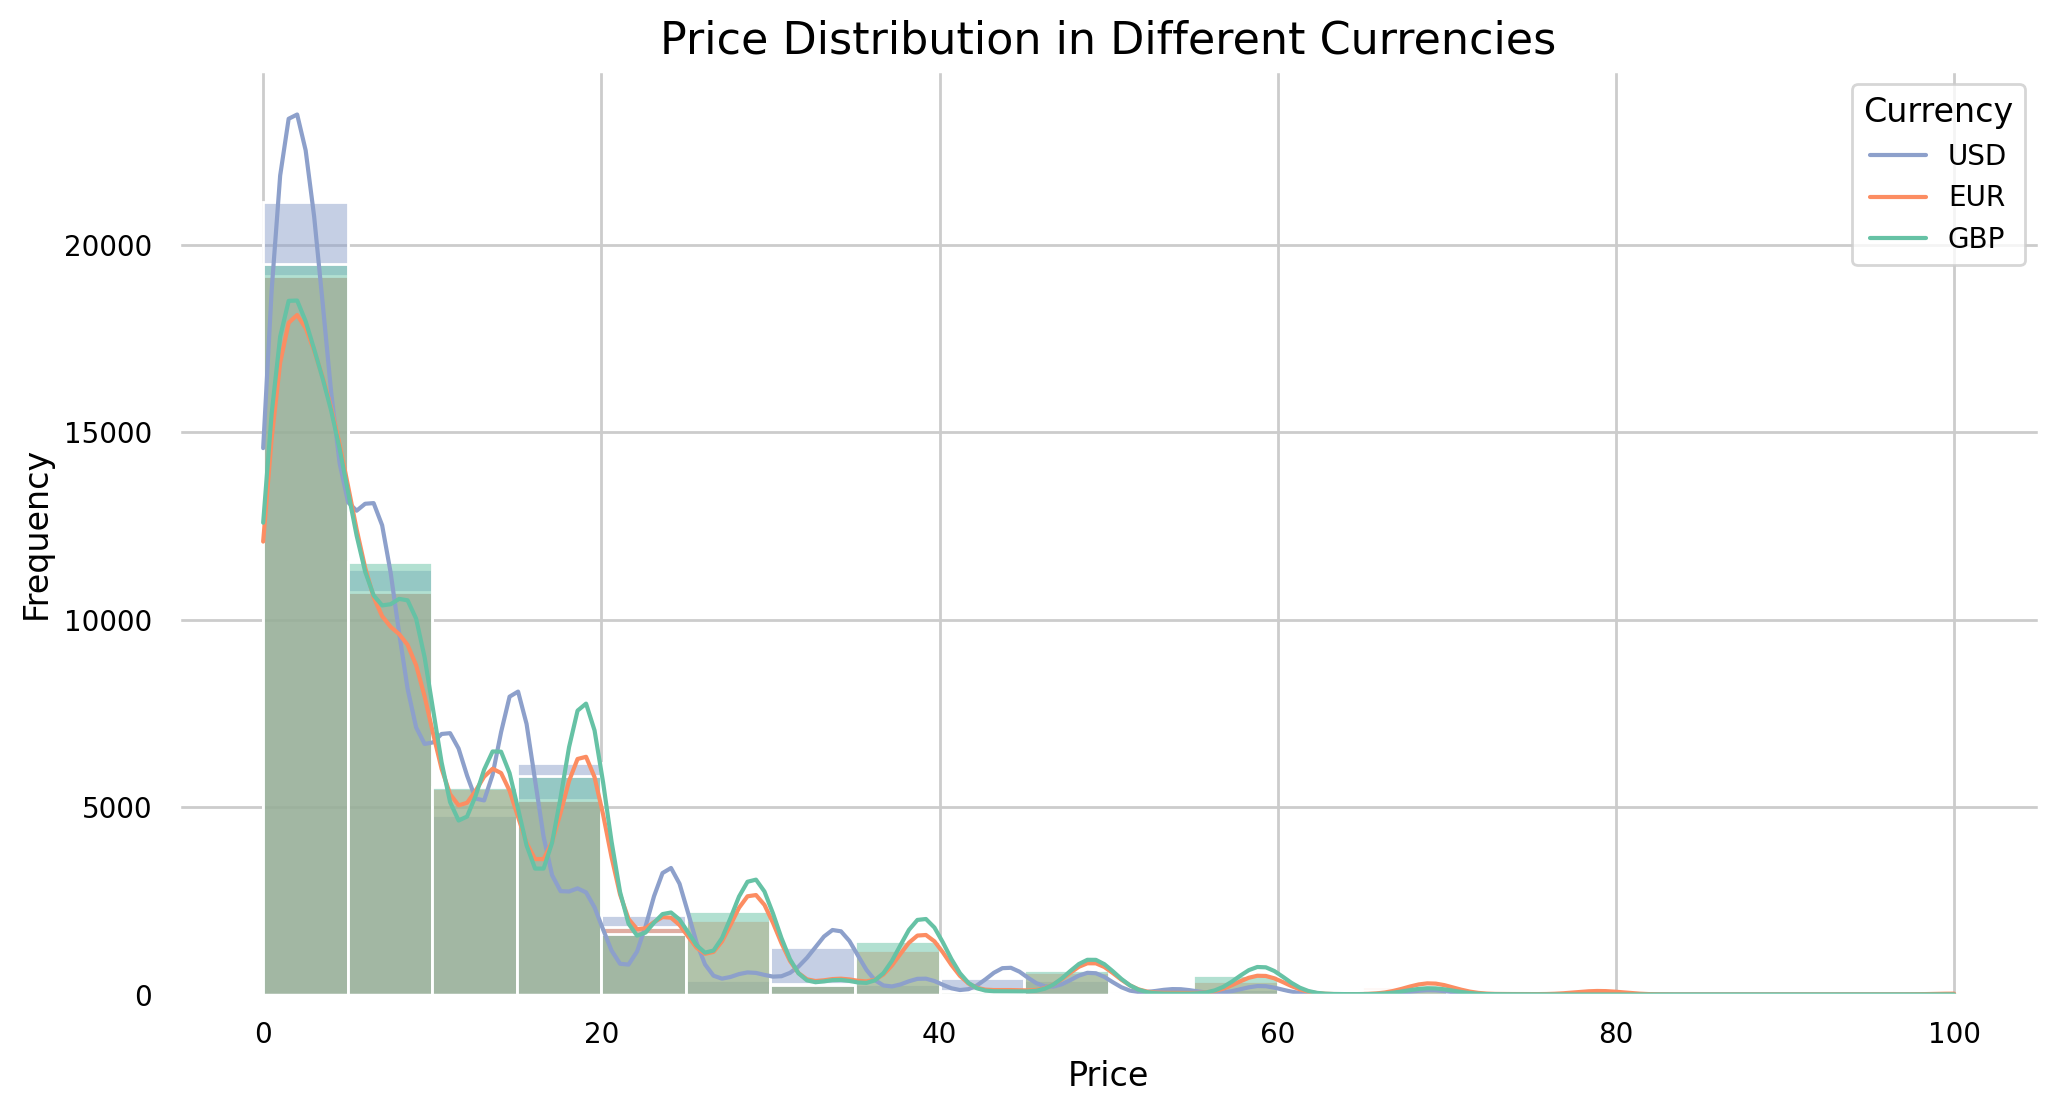

In [48]:
# Price Distribution (USD, EUR, GBP)
plt.figure(figsize=(12, 6))
sns.histplot(df_prices[['usd', 'eur', 'gbp']], kde=True, bins=20, palette="Set2")
plt.title('Price Distribution in Different Currencies', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Currency', labels=['USD', 'EUR', 'GBP'], fontsize=10)
plt.show()

/tmp/ipykernel_335/1686660028.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_achievements.values, y=top_10_achievements.index, palette='magma')


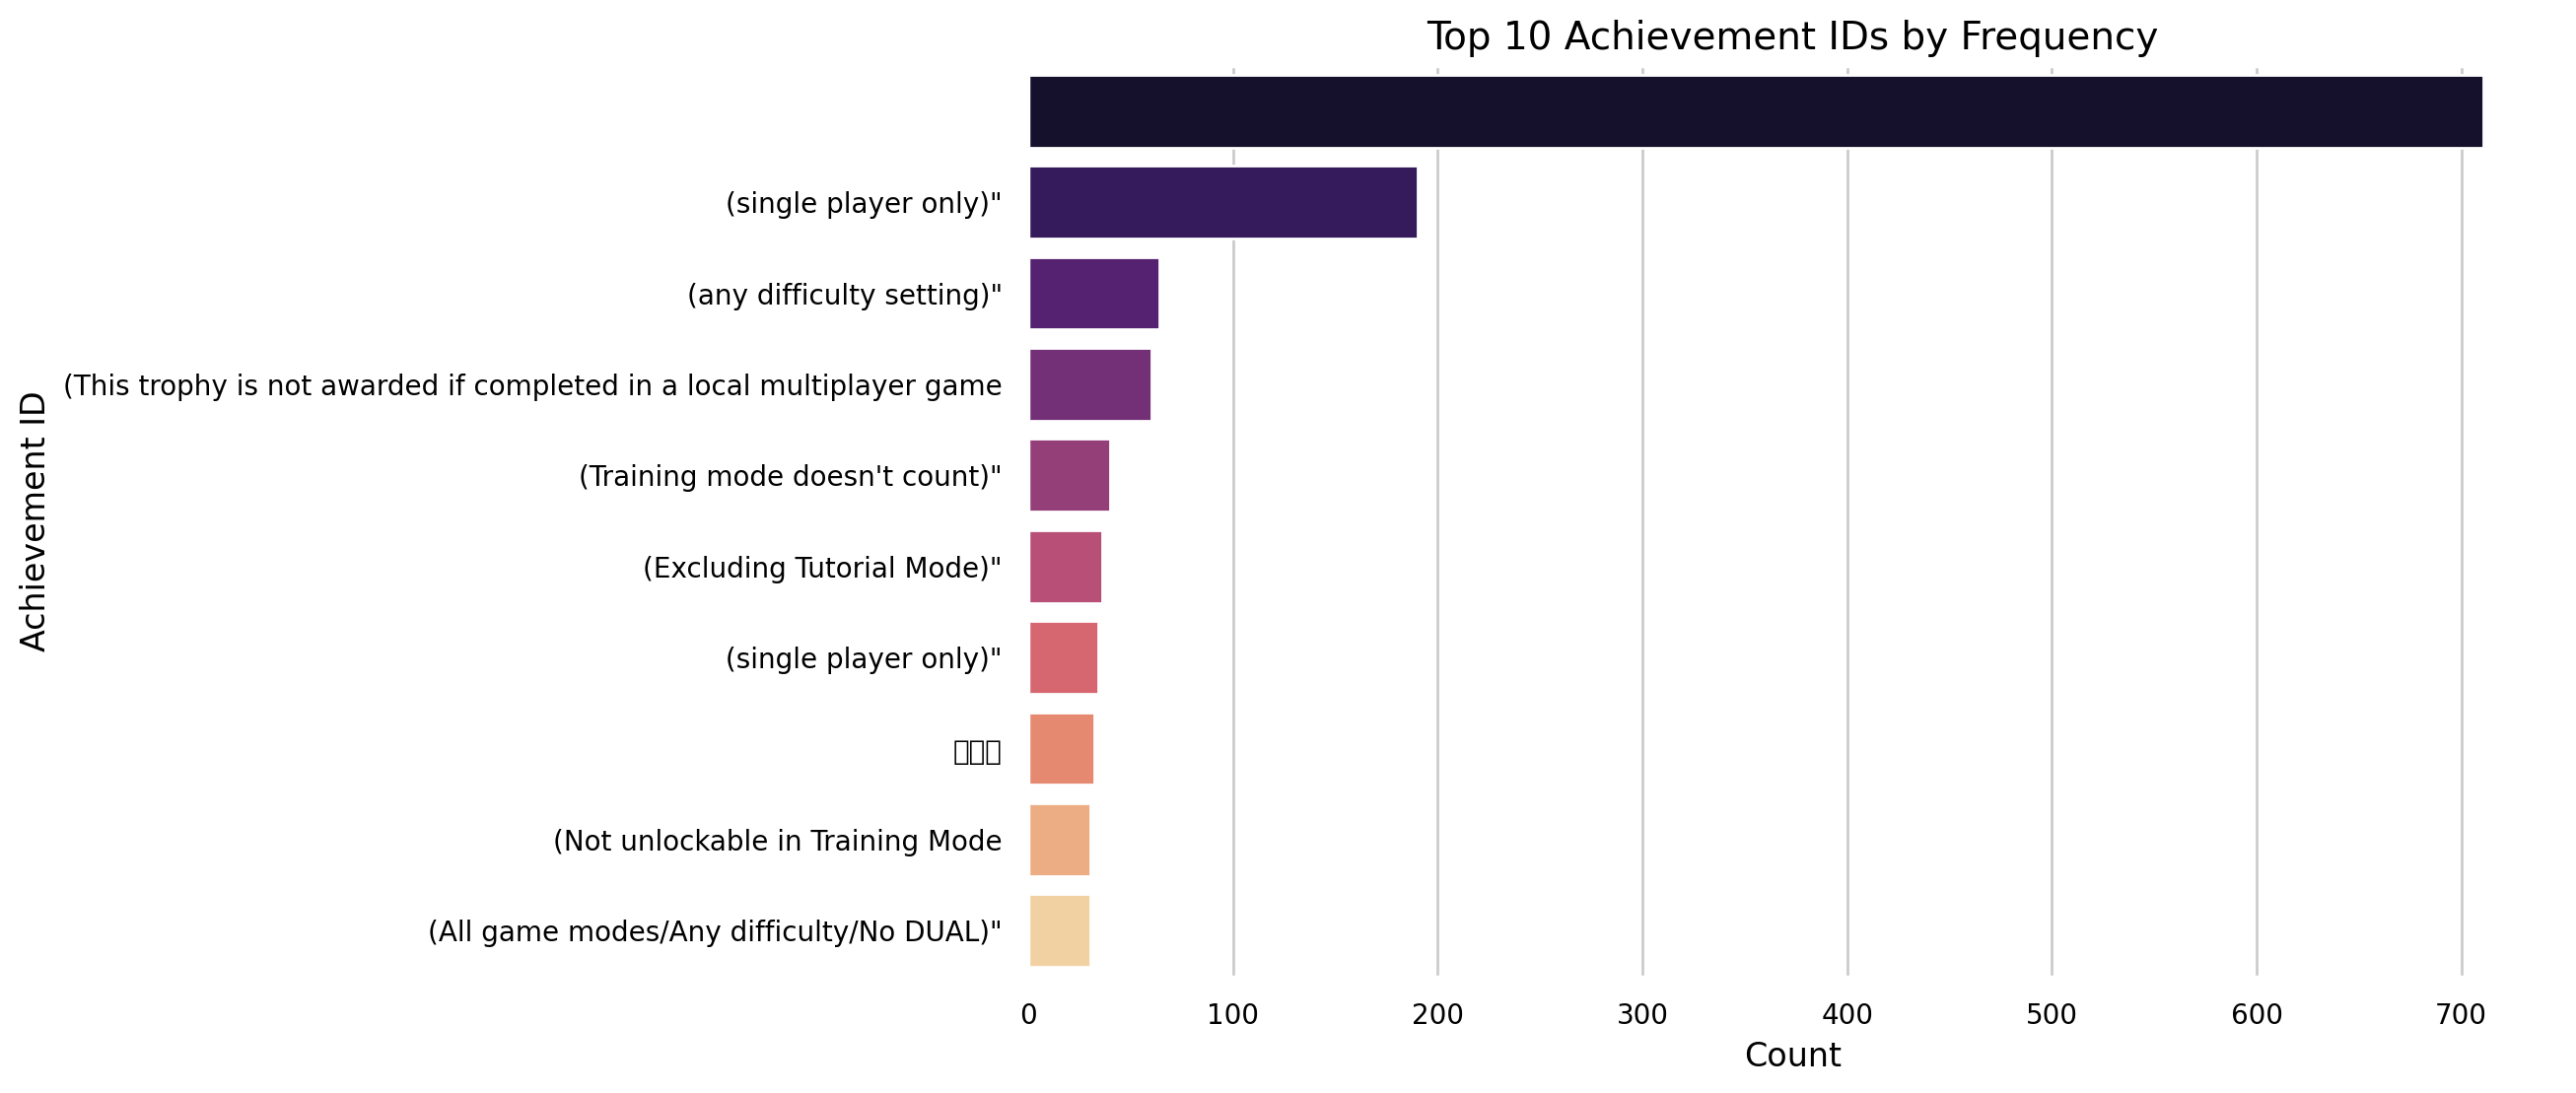

In [56]:
# Group and get top 10 most frequent achievement IDs
top_10_achievements = df_achievements['achievementid'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_achievements.values, y=top_10_achievements.index, palette='magma')

plt.title('Top 10 Achievement IDs by Frequency', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Achievement ID', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()